Es un algoritmo de búsqueda heurística que explora un gráfico expandiendo el nodo más prometedor en un conjunto limitado. En Beam Search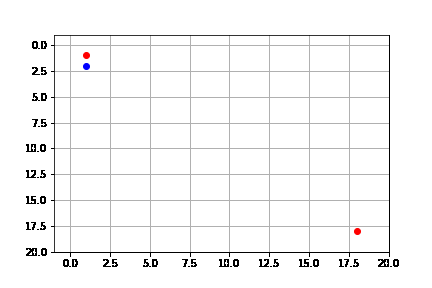 sólo se mantiene como candidata un número predeterminado de mejores soluciones parciales.

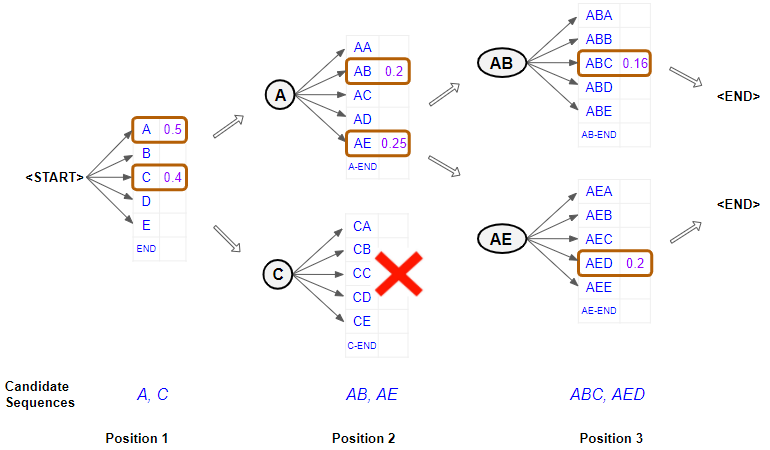

In [20]:
import numpy as np

class Maze(object):
    """Simulador de laberinto"""
    def __init__(self, board):
        #Define el laberinto
        self.board = [list(x) for x in board.split("\n") if x]
        #Guardo el estado inicial
        self.goal = None

        for y in range(len(self.board)):
            for x in range(len(self.board[y])):
                if self.board[y][x] == 'o':
                    #El inicial es el estado con el símbolo 'o'
                    self.initial = (x,y)
                elif self.board[y][x] == 'x':
                    #La meta es el estado con el símbolo 'x'
                    self.goal = (x,y)

    def __str__(self):
        return '\n'.join([''.join(symbols) for symbols in self.board])

    def actions(self, state):
        """Define las posibles acciones permitidas en cada estado"""
        actions = []
        for action in ["up","down","left","right"]:
            newx, newy = self.result(state, action)
            #Una acción no permitida es aquella donde se
            #topa con un símbolo # que indica pared
            if self.board[newy][newx] != "#":
                actions.append(action)
        return actions

    def result(self, state, action):
        """Calcula el estado resultante de la acción"""
        x, y = state
        if action.count("up"):
            y -= 1
        if action.count("down"):
            y += 1
        if action.count("left"):
            x -= 1
        if action.count("right"):
            x += 1

        new_state = (x, y)
        return new_state

    def move(self, state, new_state, symbol='o'):
        """Cambia la posición del agente de un estado a otro"""
        x,y = state
        new_x, new_y = new_state
        if self.board[new_y][new_x] == ' ':
            self.board[y][x] = ' '
            self.board[new_y][new_x] = symbol
        else:
            pass

    def cost(self, prev, action, next, normal=' ',low='.',high='-'):
        """Función de costo con base en 'tráfico'"""
        res = self.board[next[1]][next[0]]
        #Situación de costo normal
        if res == normal:
            return 1
        #Tráfico ligero
        elif res == low:
            return 2
        #Tráfico alto
        elif res == high:
            return 3
        #Casos donde está el final
        else:
            return 0

    def draw(self, low='.', high='-'):
        """Dibuja el mapa"""
        import matplotlib.pyplot as plt
        import numpy as np

        img = np.ones((len(self.board), len(self.board[0]), 4))
        for i, row in enumerate(self.board):
            for j, element in enumerate(row):
                if element == '#':
                    img[i,j] = np.array([0,0,0,1])
                elif element == 'o':
                    img[i,j] = np.array([0.2,0.5,0.8,1])
                elif element == 'x':
                    img[i,j] = np.array([0.2,0.9,0.5,1])
                elif element == high:
                    img[i,j] = np.array([1,0.2,0.2,0.4])
                elif element == low:
                    img[i,j] = np.array([0.9,0.6,0.3,0.4])

        plt.imshow(img)
        plt.show()

    def is_goal(self, state):
        """Determina si un estado es meta"""
        return state == self.goal

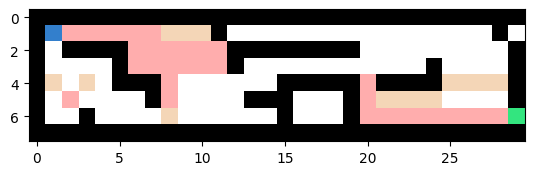

Estado inicial: (1, 1)
Estado final: (29, 6)


In [21]:
mapa = """
##############################
#o------...#                #
# ####------########         #
#    #------#           #    #
#. . ###-      #####-####....#
# -    #-    ###   #-....    #
#  #    .      #   #---------x
##############################
"""

ent = Maze(mapa)
ent.draw()

print('Estado inicial: {}\nEstado final: {}'.format(ent.initial, ent.goal))


Usamos una función de probabilidad basada en métricas, lo que define una probabilidad radial. Los elementos más cercanos a la meta son los elementos más probables.

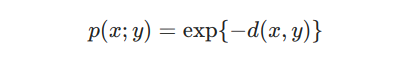


'd' es una métrica y 'y' será el nodo meta. Es decir, la probabilidad de un elemento se basará en su distancia al nodo meta. En este caso, usamos una métrica euclideana para tomar la distancia. Así, entre más cerca nos encontremos de la meta, el valor de la heurística será mayor.

In [22]:
def h(state, goal):
    """Heurísitca probabilística"""
    x1,y1 = state
    x2,y2 = goal
    #Obtiene distancia euclideana
    dist = np.sqrt((x2-x1)**2 + (y2-y1)**2)
    #Obtiene probabilidad
    probability = np.exp(-dist)
    return probability

## Cola de prioridad

La cola de prioridad que tomamos aquí es similar a las anteriores, pero en este caso la prioridad estará determinada por un valor de probabilidad definida como anteriormente; esto tiene diferentes consecuencias, la más simple es que en lugar de minimizar el valor, se busca mazimizar, aunque es claro que ambos casos son equivalentes pues basta usar el signo negativo o bien usar el inverso de la probabilidad 1/p para tener un argumento que se minimice.

El punto esencial aquí es que en cada paso la pila sólo puede contener a lo más
k elementos.

Para esto definimos un parámetro k y modificamos la función de push que antes de introducir un nuevo elemento revisa si este tiene mayor prioridad que otros en la pila. En cada caso, se quedará con los k elementos con mayor prioridad.



In [23]:
class PriorityQueue(object):
    """Clase de una cola de prioridad en los problemas de búsqueda, limitando el tamaño de pila"""
    def __init__(self,h=lambda x: 1,k=3):
        self.queue = []
        self.h = h
        self.size = k

    def __str__(self):
        return ' '.join([str(q) for q in self.queue])

    def isEmpty(self):
        """Revisa si la pila está vacía"""
        return self.queue == []

    def push(self, element):
        """Introduce un elemento, pero sólo puede contener a lo más k elementos"""
        if len(self.queue) >= self.size:
            #Si se sobrepasa el limite de elementos
            for item in self.queue:
                #Revisa cual es el de menor prioridad
                if item.f < element.f:
                    #y toma el de mayor prioridad
                    self.queue.remove(item)
                    self.queue.append(element)
        else:
            self.queue.append(element)

    def pop(self):
        """Saca el elemento con mayor prioridad"""
        argmax = np.argmax([element.f for element in self.queue])
        item = self.queue[argmax]
        del self.queue[argmax]

        return item

    def top(self):
        """Muestra el elemento en el tope de la pila"""
        argmax = np.argmax([element.f for element in self.queue])
        item = self.queue[argmax]


In [24]:
class Node(object):
    """Clase para crear nodos con sus atributos."""
    def __init__(self):
        self.state = None
        self.parent = None
        self.action = None
        self.cost = 0
        self.f = 1

    def __str__(self):
        return str(self.state)

def expand(problem, node):
    """Expansión de nodos"""
    s = node.state
    for action in problem.actions(s):
        new_s = problem.result(s, action)
        new_node = Node()

        #new_node.f = node.f * h(new_s, problem.goal):
        #Se calcula y asigna la prioridad (f) del nuevo nodo. Esto se hace multiplicando la prioridad del nodo actual (node.f) por el resultado de aplicar
        #una heurística (h) al nuevo estado (new_s) y al estado objetivo definido por problem.goal.
        new_node.state,new_node.parent,new_node.action,new_node.cost = new_s,node,action,node.cost+problem.cost(s,action,new_s)
        #Prioridad del nodo
        new_node.f = node.f*h(new_s, problem.goal)

        yield new_node

##Algoritmo Beam Search

La implementación del algoritmo Beam Search se puede resumir en los siguientes pasos:

* Seleccionar los k nodos de menor costo dado el inicial, y guardar sólo esos nodos.

* En cada nueva iteración se expande sólo los k nodos obtenidos en la iteración anterior. Los otros nodos se olvidan.

* Se conservan sólo los k  nodos con menor costo en cada iteración.

* Se repite hasta alcanzar un estado meta.

In [25]:
def BeamSearch(problem, max_size=3):
    """Algoritmo de búsqueda por haz (Beam Search)"""
    #Almacenamiento de nodos
    nodes = []
    #Nodo inicial
    node = Node()
    node.state = problem.initial
    #Frontera con cola de prioridad con límite
    frontier = PriorityQueue(k=max_size)
    frontier.push(node)
    #Nodos alcanzados
    reached = {problem.initial:node}

    #Mientras la frontera no esté vacía
    while frontier.isEmpty() == False:
        print('Tamaño de frontera: {}'.format(len(frontier.queue))) #Imprime tamaño de frontera
        #Pop en frontera
        node = frontier.pop()
        #Guarda el nodo en la lista
        nodes.append(node)
        #Actualiza el estado del problema
        problem.state = node.state

        #Si llega a un estado final se detiene
        #y regresa el camino de nodos
        if problem.state == problem.goal:
            return nodes

        #Expande el nodo actual
        expantion = expand(problem, node)
        for child in expantion:
            #print(child.f)
            #Guarda estado de los hijos
            state = child.state
            #Guarda los hijos no alcanzados o que tengan menor costo
            if state not in reached.keys() or child.f < reached[state].f:
                reached[state] = child
                frontier.push(child)

    #Si no logra llegar a un nodo final
    #El algoritmo regresa mensaje de error
    return "No se ha logrado llegar a un estado final."

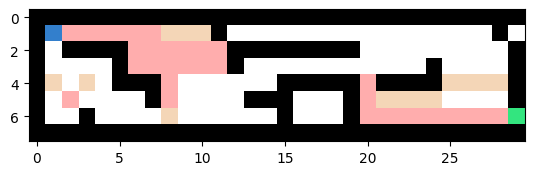

Solución


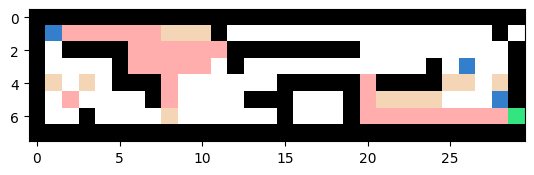

Costo total: 61


In [27]:
def get_path(search_tree, root):
    """Recupera la solución."""
    leaf = search_tree[::-1][0]
    parent = leaf.parent
    path = [leaf, parent]
    while parent.state != root:
        parent = parent.parent
        path.append(parent)

    return path[::-1]

ent.draw()
#Visualiza la solución
prev_s = ent.initial
for n in get_path(tree, ent.initial):
    ent.move(prev_s, n.state)
    prev_s = n.state

print('Solución')
ent.draw()
print('Costo total: {}'.format(tree[-1].cost))


Completeness (Completitud): La beam search no garantiza encontrar una solución, ya que depende de la heurística y de la calidad de las soluciones parciales en el haz. Puede quedarse atascado en un óptimo local o no explorar todas las posibilidades.


Optimality (Optimalidad): No garantiza la optimalidad de la solución encontrada. Puede encontrar una solución rápidamente, pero no necesariamente será la mejor en términos de la función de costo.


Exploración limitada: Debido a la limitación del tamaño del haz (beam width), el algoritmo puede pasar por alto ciertas áreas del espacio de búsqueda que podrían contener la solución óptima.


Dependencia de la heurística: La calidad de las soluciones depende en gran medida de la heurística utilizada y cómo selecciona y evalúa las soluciones parciales.

##Resumen

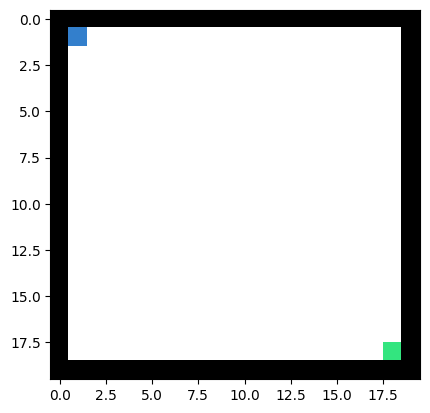

In [30]:
import numpy as np
#from maze_simulator import TrafficMaze
import matplotlib.pyplot as plt
import imageio

mapa = """
####################
#o                 #
#                  #
#                  #
#                  #
#                  #
#                  #
#                  #
#                  #
#                  #
#                  #
#                  #
#                  #
#                  #
#                  #
#                  #
#                  #
#                  #
#                 x#
####################
"""

ent = Maze(mapa)
ent.draw()

In [31]:

def heuristic(state, goal, p=2):


    return distance

In [32]:
class PriorityQueue(object):
    """Clase de una cola de prioridad en los problemas de búsqueda"""
    def __init__(self, k=None):
        self.queue = []
        self.size = k

    def __str__(self):
        return ' '.join([str(q) for q in self.queue])

    def isEmpty(self):
        return self.queue == []

    def push(self, element):
        if self.size == None:
            self.queue.append(element)
        else:
            if len(self.queue) >= self.size:
                for item in self.queue:
                    if item.f > element.f:
                        self.queue.remove(item)
                        self.queue.append(element)
                    else:
                        pass
            else:
                self.queue.append(element)

    def pop(self):
        min_element = np.argmin([element.f for element in self.queue])
        item = self.queue[min_element]
        del self.queue[min_element]

        return item

    def top(self):
        min_element = np.argmin([element.f for element in self.queue])
        item = self.queue[min_element]

        return item

class Node(object):
    """Clase para crear nodos con sus atributos"""
    def __init__(self):
        self.state = None
        self.parent = None
        self.action = None
        self.path_cost = 0
        self.depth = 0
        self.f = 0

    def __str__(self):
        return str(self.state)

def expand(problem, node, method='Astar',p=1):
    """Función para expandir los nodos dado el problema"""
    s = node.state
    for action in problem.actions(s):
        new_s = problem.result(s, action)

        new_node,new_node.state,new_node.parent,new_node.action = Node(),new_s,node,action
        new_node.depth = node.depth + 1
        new_node.path_cost = heuristic(new_s,problem.initial,p=2)
        if method == 'Astar':
            new_node.f = new_node.path_cost + heuristic(new_s,problem.goal,p=p)
        elif method == 'Dijkstra':
            new_node.f = new_node.path_cost
        elif method == 'Breadth':
            new_node.f = new_node.depth
        elif method == 'Depth':
            new_node.f = -new_node.depth
        else:
            print("No es algoritmo válido")

        yield new_node

In [33]:
from copy import deepcopy

def canvas2rgb_array(canvas):
    """Adapted from: https://stackoverflow.com/a/21940031/959926"""
    canvas.draw()
    buf = np.frombuffer(canvas.tostring_rgb(), dtype=np.uint8)
    ncols, nrows = canvas.get_width_height()
    scale = round(np.sqrt(buf.size / 3 / nrows / ncols))
    return buf.reshape(scale * nrows, scale * ncols, 3)

def get_canvas(result, name='output'):
    steps = []
    board = deepcopy(ent.board)
    figure = plt.figure()
    plt.grid(linewidth=1)
    plt.ylim(20,-1)
    plt.xlim(-1,20)
    x_in, y_in = ent.initial
    x_g, y_g = ent.goal
    plt.scatter(x_in,y_in,c='r')
    plt.scatter(x_g,y_g,c='r')
    for node in result[1:-1]:
        x,y = node.state
        plt.scatter(x, y, c='b')
        steps.append(canvas2rgb_array(figure.canvas))

    imageio.mimsave(name+'.gif', steps)


def get_path(leaf, path=[]):
    """Función para recuperar el camino de un nodo"""
    if leaf.parent == None:
        return [leaf]+path
    else:
        return get_path(leaf.parent, path=[leaf]+path)

def get_solution(result):
    """Muestra la solución"""
    ent_a = deepcopy(ent)
    for n in get_path(result[-1]):
        x,y = n.state
        ent_a.board[y][x] = 'o'

    ent_a.draw()

##Primero en profundidad

In [34]:
def search(problem, method, p=2, beam=None):
    """Algoritmos de búsqueda"""
    nodes = []
    node = Node()
    node.state = problem.initial
    frontier = PriorityQueue(k=beam)
    frontier.push(node)
    reached = {str(problem.initial):node}

    while frontier.isEmpty() == False:
        node = frontier.pop()
        nodes.append(node)
        if node.state == problem.goal:
            return nodes

        for child in expand(problem, node, method=method, p=p):
            state = child.state
            if str(state) not in reached.keys():
                reached[str(state)] = child
                frontier.push(child)

    print("No se ha logrado llegar a un estado final.")
    return nodes

Nodos de ábol: 171
Costo solución: 24.04
Profundidad solución: 170


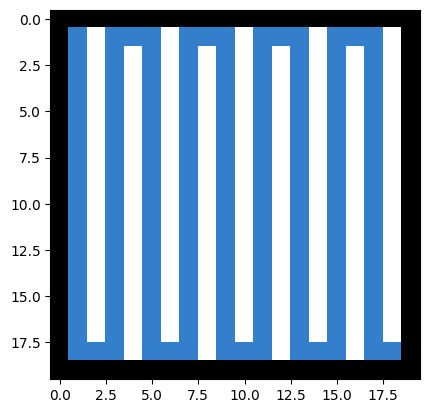

CPU times: user 174 ms, sys: 104 ms, total: 278 ms
Wall time: 243 ms


In [39]:
%%time
result_depth = search(ent, method='Depth')
print('Nodos de ábol: {}\nCosto solución: {}\nProfundidad solución: {}'.format( len(result_depth), round(result_depth[-1].path_cost,2), result_depth[-1].depth ))

get_solution(result_depth)

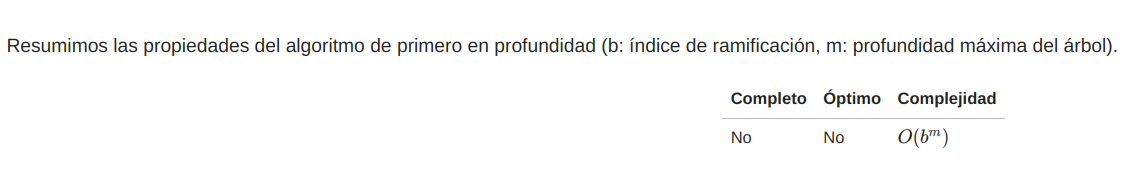

##Primero en Amplitud

Nodos de ábol: 324
Costo solución: 24.04
Profundidad solución: 34


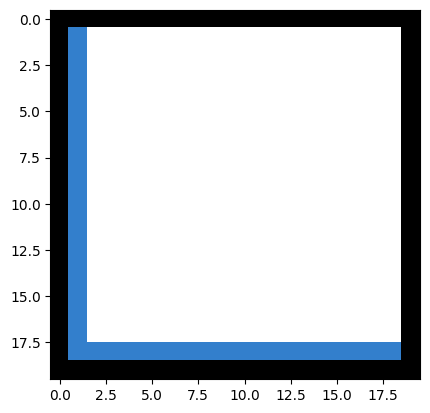

CPU times: user 161 ms, sys: 111 ms, total: 272 ms
Wall time: 156 ms


In [40]:
%%time
result_breadth = search(ent, method='Breadth')
print('Nodos de ábol: {}\nCosto solución: {}\nProfundidad solución: {}'.format( len(result_breadth), round(result_breadth[-1].path_cost,2), result_breadth[-1].depth ))

get_solution(result_breadth)



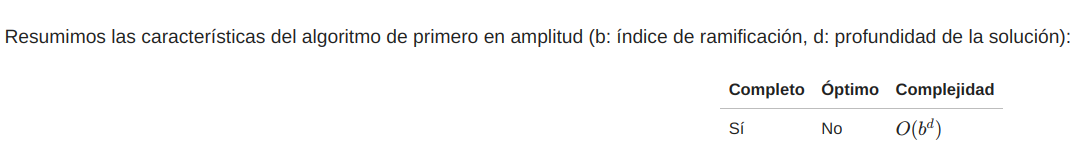

##A*

Nodos de ábol: 75
Costo solución: 24.04
Profundidad solución: 34


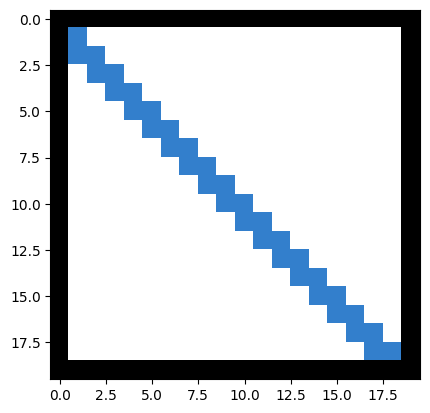

CPU times: user 173 ms, sys: 91.5 ms, total: 264 ms
Wall time: 151 ms


In [41]:
%%time
result_a = search(ent, method='Astar',p=2)
print('Nodos de ábol: {}\nCosto solución: {}\nProfundidad solución: {}'.format( len(result_a), round(result_a[-1].path_cost,2), result_a[-1].depth ))

get_solution(result_a)

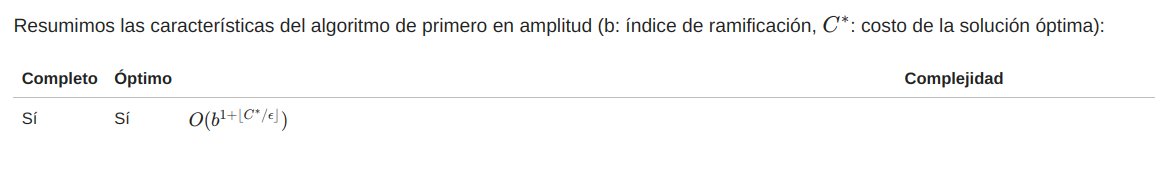

##Beam Search

Nodos de ábol: 48
Costo solución: 24.04
Profundidad solución: 34


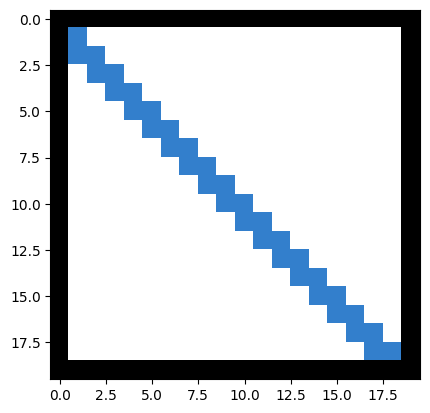

CPU times: user 157 ms, sys: 105 ms, total: 262 ms
Wall time: 149 ms


In [44]:
%%time
result_beam = search(ent, method='Astar', p=2, beam=3)
print('Nodos de ábol: {}\nCosto solución: {}\nProfundidad solución: {}'.format( len(result_beam), round(result_beam[-1].path_cost,2), result_beam[-1].depth ))
get_solution(result_beam)

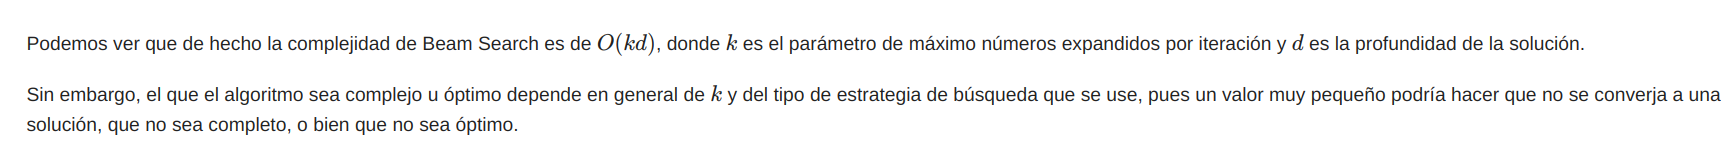